# **Ejercicio Semana 11: Clasificación de la calidad de limones**

Visión por Computador

Ingeniería Agronómica

Monica Paola Vargas Tirado

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import joblib
import random
import shutil
import warnings
import numpy as np
import keras_tuner
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from skopt import gp_minimize
from collections import Counter
import matplotlib.pyplot as plt
from skimage.feature import hog
from kerastuner.tuners import RandomSearch
from sklearn.metrics import accuracy_score
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import image
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

<ipython-input-5-39916cfd1b35>:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


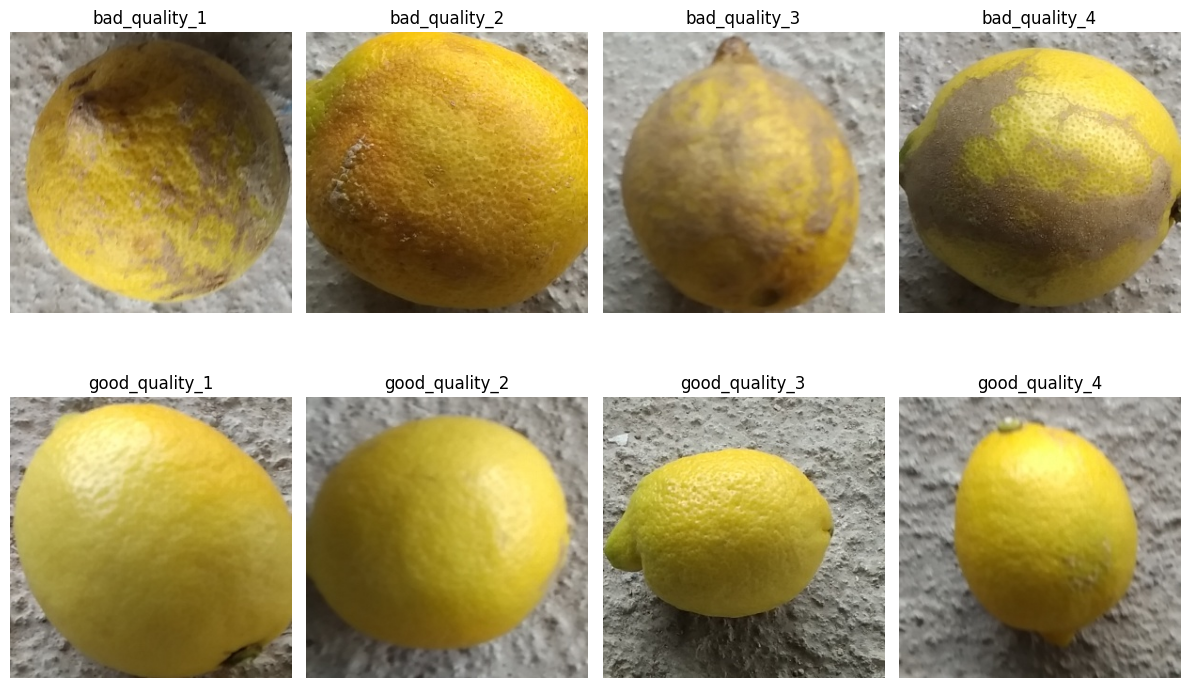

In [ ]:
base_dir = '/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Lemon_quality'
specific_folders = ['bad_quality', 'good_quality']

# Listas para almacenar imágenes y etiquetas
images = []
labels = []

# Número máximo de imágenes por carpeta
max_images_per_folder = 4

for folder in specific_folders:
    folder_path = os.path.join(base_dir, folder)
    image_count = 0
    for filename in os.listdir(folder_path):
        if image_count >= max_images_per_folder:
            break
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)  # Cargar la imagen usando OpenCV
        if img is not None:
            images.append(img)
            labels.append(folder)
            image_count += 1

# Mostrar las primeras imágenes de cada carpeta
num_folders = len(specific_folders)
plt.figure(figsize=(12, 8))
for i, folder in enumerate(specific_folders):
    folder_images = [img for img, lbl in zip(images, labels) if lbl == folder]
    for j, img in enumerate(folder_images[:max_images_per_folder]):
        plt.subplot(num_folders, max_images_per_folder, i * max_images_per_folder + j + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'{folder}_{j+1}')
        plt.axis('off')

plt.tight_layout()
plt.show()

Carpeta: bad_quality, Número de imágenes: 951
Carpeta: good_quality, Número de imágenes: 1125


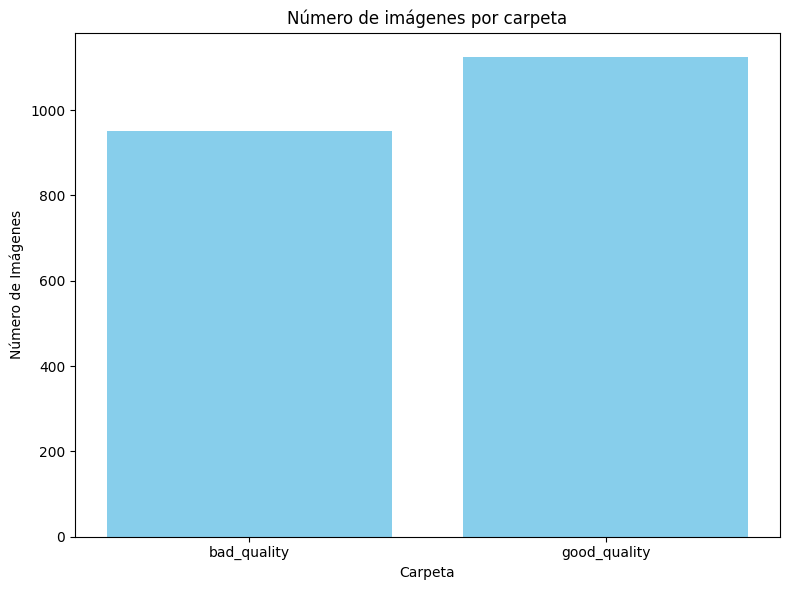

In [ ]:
import os
import matplotlib.pyplot as plt

# Directorio base
base_dir = '/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Lemon_quality'

# Carpetas específicas
specific_folders = ['bad_quality', 'good_quality']

# Lista para almacenar el número de imágenes por carpeta
num_images = []

# Iterar sobre las carpetas específicas
for folder in specific_folders:
    folder_path = os.path.join(base_dir, folder)
    # Contar el número de archivos con extensión de imagen en la carpeta
    image_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
    num_images.append(image_count)
    # Imprimir el nombre de la carpeta y la cantidad de imágenes
    print(f'Carpeta: {folder}, Número de imágenes: {image_count}')

# Graficar
plt.figure(figsize=(8, 6))
plt.bar(specific_folders, num_images, color='skyblue')
plt.xlabel('Carpeta')
plt.ylabel('Número de Imágenes')
plt.title('Número de imágenes por carpeta')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Regresión Logística

## HOG

Folder 'bad_quality' asignado como clase 0


100%|██████████| 951/951 [01:20<00:00, 11.82it/s]


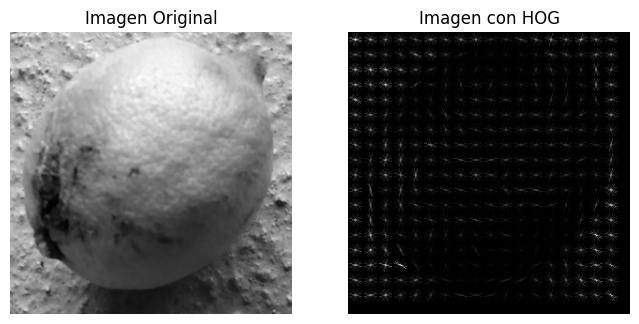

Folder 'good_quality' asignado como clase 1


100%|██████████| 1125/1125 [01:45<00:00, 10.65it/s]


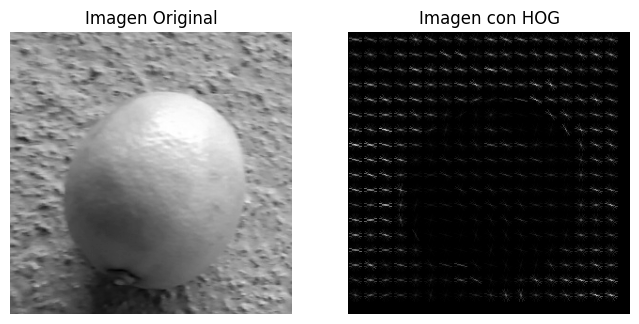

In [ ]:
# Directorio base
base_dir = '/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Lemon_quality'

# Carpetas específicas
specific_folders = ['bad_quality', 'good_quality']

# Función para calcular el HOG de una imagen
def calculate_hog(image):
    # Calcula el HOG
    hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=True)
    return hog_features, hog_image

# Lista para almacenar los datos
data = []

# Diccionario para mapear nombres de carpeta a números
folder_mapping = {}

# Itera sobre las carpetas específicas
for class_label, folder_name in enumerate(specific_folders):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        # Asigna un número a la carpeta y guarda en el diccionario
        folder_mapping[folder_name] = class_label
        print(f"Folder '{folder_name}' asignado como clase {class_label}")

        # Itera sobre cada imagen en la carpeta
        for img_name in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, img_name)
            if os.path.isfile(img_path):
                # Lee la imagen
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                # Calcula el HOG
                hog_features, _ = calculate_hog(img)
                # Agrega los datos a la lista
                data.append([img_name, folder_name, class_label] + hog_features.tolist())

        # Selecciona una imagen aleatoria
        random_img_name = random.choice(os.listdir(folder_path))
        random_img_path = os.path.join(folder_path, random_img_name)

        # Lee la imagen aleatoria
        random_img = cv2.imread(random_img_path, cv2.IMREAD_GRAYSCALE)

        # Calcula el HOG y la imagen HOG de la imagen aleatoria
        hog_features, hog_image = calculate_hog(random_img)

        # Visualiza la imagen original y la imagen HOG
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(random_img, cmap='gray')
        plt.title('Imagen Original')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title('Imagen con HOG')
        plt.axis('off')
        plt.show()

# Crea el DataFrame
columns = ['filename', 'folder', 'class'] + [f'hog_{i}' for i in range(len(data[0]) - 3)]
df = pd.DataFrame(data, columns=columns)

# Guarda el DataFrame en un archivo CSV
df.to_csv('/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/hog_features.csv', index=False)

In [ ]:
# Imprimir el mapeo de clases
print("Mapeo de clases:")
for class_name, class_id in folder_mapping.items():
    print(f"{class_name}: {class_id}")

Mapeo de clases:
bad_quality: 0
good_quality: 1


In [ ]:
# Cargar los datos
data = pd.read_csv("/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/hog_features.csv")

# Separar las características (X) y la variable objetivo (y)
X = data.drop(columns=["filename", "folder", "class"])
y = data["class"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo de regresión logística
model = LogisticRegression(multi_class='ovr', max_iter=5000)
model.fit(X_train, y_train)

# Guardar el modelo entrenado en un archivo
joblib.dump(model, "/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Modelos/logistic_regression_HOG.pkl")

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Pecisión general del modelo (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8918269230769231


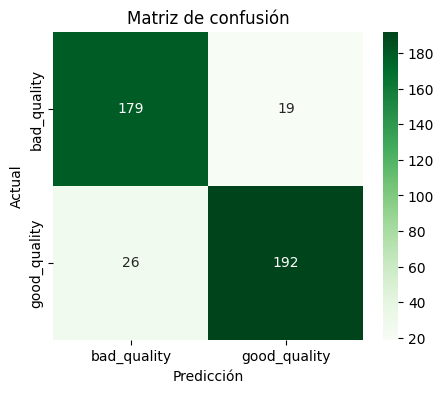

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d",
            xticklabels=['bad_quality', 'good_quality'],
            yticklabels=['bad_quality', 'good_quality'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

### Optimización de Hiper-parámetros (GridSearchCV)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/hog_features.csv")
X = data.drop(columns=["filename", "folder", "class"])
y = data["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [ ]:
# Definición del modelo
model = LogisticRegression(multi_class='ovr', max_iter=5000)

# Definición del rango de hiperparámetros para GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearch
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'C': 1, 'solver': 'saga'}


In [ ]:
joblib.dump(best_model, "/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Modelos/logistic_regression_HOG_best.pkl")

['/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Modelos/logistic_regression_HOG_best.pkl']

Accuracy: 0.8918269230769231


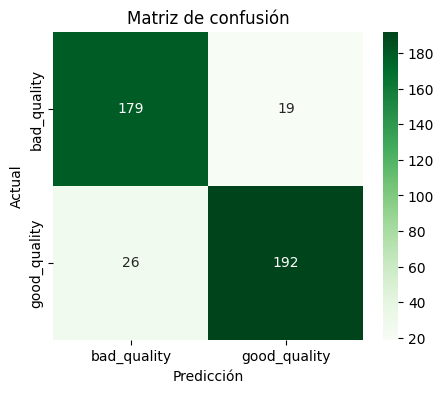

In [ ]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d",
            xticklabels=['bad_quality', 'good_quality'],
            yticklabels=['bad_quality', 'good_quality'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

### Optimización de Hiper-parámetros (RandomizedSearchCV)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/hog_features.csv")
X = data.drop(columns=["filename", "folder", "class"])
y = data["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definición del modelo
model = LogisticRegression(multi_class='ovr', max_iter=5000)

# Definición del rango de hiperparámetros para RandomizedSearch
param_dist = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Mejor modelo encontrado por RandomizedSearch
best_model = random_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros encontrados:
{'solver': 'saga', 'C': 1}


In [ ]:
joblib.dump(best_model, "/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Modelos/logistic_regression_HOG_best.pkl")


['/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Modelos/logistic_regression_HOG_best.pkl']

Accuracy: 0.8918269230769231


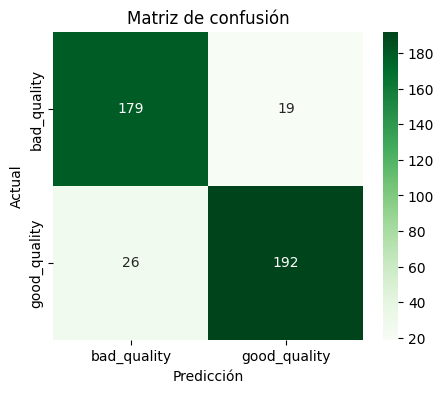

In [ ]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d",
            xticklabels=['bad_quality', 'good_quality'],
            yticklabels=['bad_quality', 'good_quality'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

# Red neuronal

In [ ]:
original_dir = '/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Lemon_quality'

base_dir = '/content/drive/MyDrive/UNIVERSIDAD EAFIT/VISION POR COMPUTADOR/EJERCICIOS/Dataset/Lemon_quality_dataset'
os.makedirs(base_dir, exist_ok=True)

categories = ['good_quality', 'bad_quality']

In [ ]:
for category in categories:
    os.makedirs(os.path.join(base_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', category), exist_ok=True)

for category in categories:
    category_dir = os.path.join(original_dir, category)
    file_list = os.listdir(category_dir)

    train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
    valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    for file_name in train_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'train', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in valid_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'validation', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in test_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'test', category, file_name)
        shutil.copyfile(src, dst)

for split in ['train', 'validation', 'test']:
    for category in categories:
        category_dir = os.path.join(base_dir, split, category)
        print(f"{split} {category} images: {len(os.listdir(category_dir))}")

train good_quality images: 900
train bad_quality images: 760
validation good_quality images: 112
validation bad_quality images: 95
test good_quality images: 113
test bad_quality images: 96


In [ ]:
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 1660 images belonging to 2 classes.
Found 207 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


In [ ]:
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv2_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv3_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner',
    project_name='lemon_quality')

tuner.search(train_generator,
             validation_data=valid_generator,
             epochs=10,
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Trial 5 Complete [00h 01m 01s]
val_accuracy: 0.9855072498321533

Best val_accuracy So Far: 0.990338146686554
Total elapsed time: 00h 05m 21s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 112)     3136      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 112)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        32288     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 48)

In [ ]:
# Definición del modelo
model = Sequential([
    Conv2D(112, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(48, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(96, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/10
51/51 [==============================] - 7s 116ms/step - loss: 0.5240 - accuracy: 0.7297 - val_loss: 0.2254 - val_accuracy: 0.9219
Epoch 2/10
51/51 [==============================] - 6s 113ms/step - loss: 0.2193 - accuracy: 0.9091 - val_loss: 0.1965 - val_accuracy: 0.9427
Epoch 3/10
51/51 [==============================] - 6s 119ms/step - loss: 0.1430 - accuracy: 0.9398 - val_loss: 0.1420 - val_accuracy: 0.9531
Epoch 4/10
51/51 [==============================] - 6s 115ms/step - loss: 0.1047 - accuracy: 0.9613 - val_loss: 0.0965 - val_accuracy: 0.9583
Epoch 5/10
51/51 [==============================] - 6s 113ms/step - loss: 0.2085 - accuracy: 0.9183 - val_loss: 0.3636 - val_accuracy: 0.8594
Epoch 6/10
51/51 [==============================] - 6s 118ms/step - loss: 0.1802 - accuracy: 0.9300 - val_loss: 0.1023 - val_accuracy: 0.9583
Epoch 7/10
51/51 [==============================] - 6s 114ms/step - loss: 0.0848 - accuracy: 0.9699 - val_loss: 0.0649 - val_accuracy: 0.9792
Epoch 

In [ ]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy}')

6/6 [==============================] - 1s 102ms/step - loss: 0.2057 - accuracy: 0.9323
Test accuracy: 0.9322916865348816


1/1 [==============================] - 0s 25ms/step


<ipython-input-17-534be42660ef>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_labels[int(y[i])]}\nPred: {class_labels[int(predictions[i] > 0.5)]}")


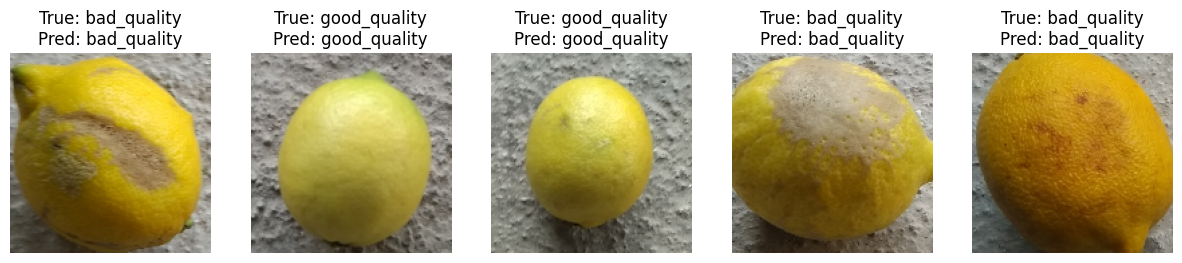

In [ ]:
# Función para mostrar imágenes con predicciones
def show_predictions(model, generator, class_labels, num_images=5):
    x, y = next(generator)
    predictions = model.predict(x)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x[i])
        plt.title(f"True: {class_labels[int(y[i])]}\nPred: {class_labels[int(predictions[i] > 0.5)]}")
        plt.axis('off')
    plt.show()

# Etiquetas de clase
class_labels = list(train_generator.class_indices.keys())

# Mostrar predicciones en el conjunto de prueba
show_predictions(model, test_generator, class_labels, num_images=5)